# Project TC5 - Audio signal declipping

Name: Jingzhuo HUI, You ZUO

Date: 07/01/2021

In [48]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

import librosa
import librosa.display

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
# load wav file
# sr: how many times per second a sound is sampled
audio_file = "nt_toolbox/data/female.wav"
audio, sr = librosa.load(audio_file,sr=None, mono = True, offset = 0.0, duration = None)

print("Audio:",[len(audio),sr],len(audio)/sr,"seconds")


Audio: [160000, 16000] 10.0 seconds


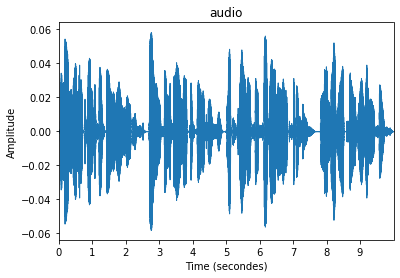

In [3]:
librosa.display.waveplot(y = audio, sr = sr) 
plt.xlabel("Time (secondes)")
plt.ylabel("Amplitude")
plt.title("audio") 
plt.show()

As we can see from the plots above, the audio signals have already been normalized. We choose firstly a clip level $\theta ^{clip} = 0.4$

In [4]:
# function to clip our signal with a given clip level
def clipping_audio(signal,level):
    scaling = max(abs(audio))
    signaltmp = signal / scaling 

    remain_ratio = 1-level
    
    signaltmp[abs(signaltmp) > remain_ratio] *= remain_ratio

    return signaltmp * scaling

clipped_audio = clipping_audio(audio,0.4)

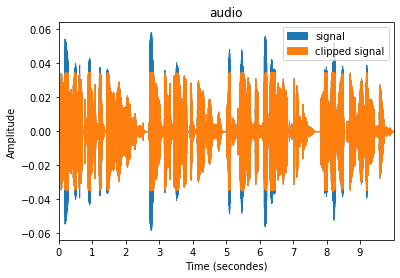

In [5]:
librosa.display.waveplot(y = audio,sr =sr, label='signal') 
librosa.display.waveplot(y = clipped_audio, sr=sr , label='clipped signal') 
plt.xlabel("Time (secondes)")
plt.ylabel("Amplitude")
plt.title("audio") 
plt.legend()
plt.show()

## relatex version of ISTA

In [8]:
##  Mr ∈ RM×T is a matrix comprised of those rows of the 
## identity matrix that choose the entries of the reliable samples.
def picking_reliable(clipped_audio):
    """
    returns the diagnal matrix to pick the reliable/clipped samples
    of clipped signal
    """
    clipping = max(clipped_audio)
    n = len(clipped_audio)

    pick = np.array([1 if abs(clipped_audio[i]) < (clipping - 10e-3) else 0 for i in range(n)]) 
    clip = 1-pick
    
    return pick, clip

In [34]:
# initialization 
ETA = 0.9
k = 1
LAMBDA = 0.01 
L = 1

theta_clip = max(abs(clipped_audio))
y = clipped_audio

Mr, Mc = picking_reliable(clipped_audio)
xinv = np.zeros(Mr.shape[0])
zinv = xinv.copy()

In [35]:
# compute the gradients
g1 = - np.transpose(Mr) * (Mr * (y - zinv))
g2 = - np.transpose(Mc) * (Mc * (theta_clip - zinv))

xinv_unthesh = zinv - (g1+g2)

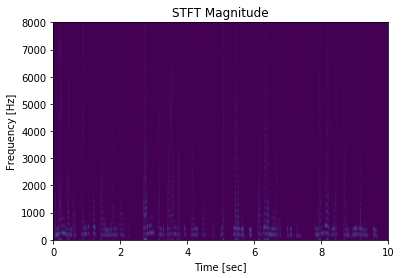

In [36]:
# applying a tight Gabor frame1 as time-frequency dictionary
from scipy import signal

f, t, axx = signal.stft(x=xinv_unthesh, fs=sr)
plt.pcolormesh(t, f, np.abs(axx), vmin=0, vmax=max(clipped_audio), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [42]:
# thresholding
SoftThresh = lambda x, T: x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))
axx = SoftThresh(axx, LAMBDA/L)
_, xrec = signal.istft(axx, fs=sr)

In [46]:
from numpy import linalg as LA
theta = LA.norm(axx @ np.asmatrix(axx).H)
theta

0.0001436137516419046

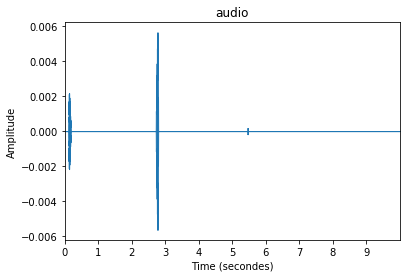

In [83]:
librosa.display.waveplot(y = xrec, sr = sr) 
plt.xlabel("Time (secondes)")
plt.ylabel("Amplitude")
plt.title("audio") 
plt.show()

In [78]:
from nt_toolbox.perform_stft import *

x = perform_stft(perform_stft(audio,w=256,q=1,n=1024),w=256,q=1,n=1024)



In [69]:
stft.shape

(256, 18)

In [67]:
LA.norm(stft @ np.transpose(stft))

0.011534614748969824

In [70]:
plt.pcolormesh(65, 256, np.abs(stft), vmin=0, vmax=max(stft), shading='gouraud')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()